# Human action recognition, YOLOv5

This notebook demonstrates the use of YOLO5 for human action recognition. The YOLO5 recognizes the humans in a video frame and returns the bounding boxes and class labels. The bounding boxes are then used to crop the image and the cropped image is then passed to the neural network to classify the action.

In [671]:
# Install prerequisites for YOLOv5:
%pip install torch
%pip install opencv-python
%pip install pandas
%pip install seaborn
%pip install pytesseract
# %pip install gluoncv mxnet




Note: you may need to restart the kernel to use updated packages.



In [1084]:
import ast
import cv2
import datetime
# from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pytesseract
import random
import re
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
import sklearn
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline
# Use seed for reproducibility of results
SEED = 1234
torch.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Download the YOLOv5 model from torch.hub.

In [13]:
yolo5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Test on a single image
img = cv2.imread('./zidane.jpg')
with torch.no_grad():
    results = yolo5(img)
print(results.pandas().xyxy[0])

Using cache found in C:\Users\USER/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-9-2 Python-3.10.4 torch-1.12.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


         xmin        ymin         xmax        ymax  confidence  class    name
0  743.737183   45.197662  1149.868530  720.000000    0.857245      0  person
1  120.321350  197.517731   853.214905  718.736206    0.620563      0  person
2  439.619629  437.163513   500.712646  711.709778    0.252843     27     tie


Plot the bounding boxes on the image.

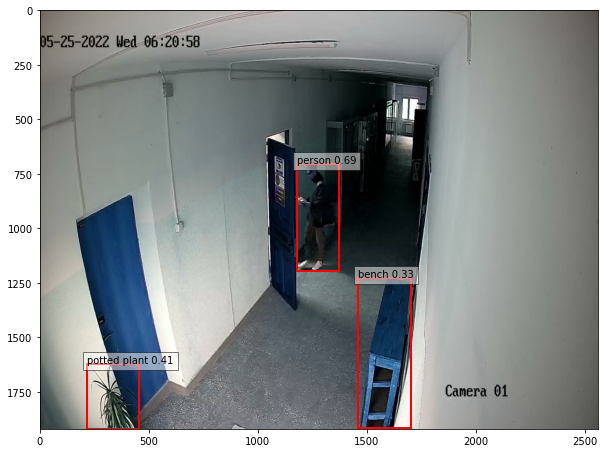

In [487]:
# Visualize bounding boxes with confidence scores
def plot_bbox(img, bboxes, class_labels=None, confidence_scores=None, class_names=None, colors=None,
              save_path=None):
    """
    Plot bounding boxes on image.

    Params:
        img (ndarray): input image
        bboxes (ndarray): bounding boxes of shape (N, 4)
        colors (dict): colors for class labels
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    
    ax.imshow(img)

    # Show random colors if no colors are provided
    if colors is None:
        colors = dict()
        
    for i in range(len(bboxes)):
        x1, y1, x2, y2 = bboxes[i]

        # Each class has its own color
        #cls_id = class_labels[i] if class_labels is not None else -1
        #if cls_id not in colors.keys():
        #    colors[cls_id] = np.random.rand(3)

        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        if class_names is not None:
            text = class_names[i]
        elif class_labels is not None:
            text = class_labels[i]
        else:
            text = '???'

        if confidence_scores is not None:
            text += ' {:.2f}'.format(confidence_scores[i])
        ax.text(x1, y1, text, bbox={'facecolor': 'white', 'alpha': 0.5})
    
    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# Dataframe with columns 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'
results_df = results.pandas().xyxy[0]
bboxes = results_df[['xmin', 'ymin', 'xmax', 'ymax']].values
# Convert img to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_bbox(img, bboxes, class_labels=results_df['class'].values, confidence_scores=results_df['confidence'].values, class_names=results_df['name'].values)

          xmin        ymin         xmax         ymax  confidence  class  \
0  1264.776367  812.316223  1374.355713  1034.937256    0.283589     58   

           name  
0  potted plant  


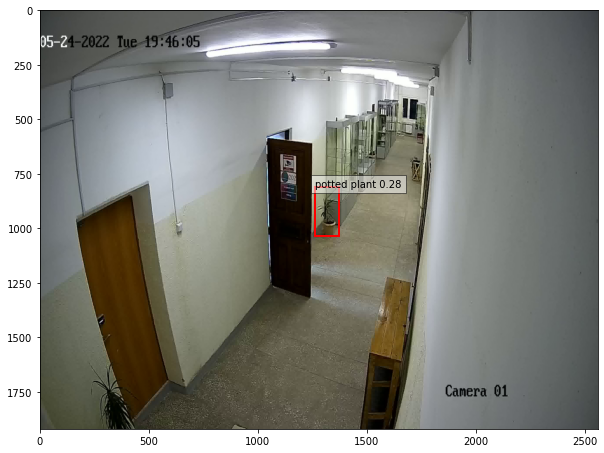

In [15]:
# Test on a random frame from the video
cap = cv2.VideoCapture('G:\\IT\Datasets\\Irkutsk\\train_dataset_train\\train\\train1.avi')
# Get random frame from video
cap.set(cv2.CAP_PROP_POS_FRAMES, np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT)))
ret, img = cap.read()
with torch.no_grad():
    results = yolo5(img)
print(results.pandas().xyxy[0])

results_df = results.pandas().xyxy[0]
bboxes = results_df[['xmin', 'ymin', 'xmax', 'ymax']].values
# Convert img to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_bbox(img, bboxes, class_labels=results_df['class'].values, confidence_scores=results_df['confidence'].values, class_names=results_df['name'].values)

In [1092]:
RUN_LOCAL = True
PREPARE_AUGMENTED_DATASET = True
ENABLE_DETAILED_TEST = True
USE_PRETRAINED_MODEL = False

if RUN_LOCAL:
    TESSERACT_PATH = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
    TRAIN1_VIDEO_PATH = "train1.avi"
    TRAIN2_VIDEO_PATH = "train2.avi"
    TEST_VIDEO_PATH = "test.avi"
    TRAIN_PATH = "train.csv"
else:
    # Insert your paths here
    TESSERACT_PATH = '/usr/bin/tesseract'

pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

# Preprocessing

Since the `train.csv` file `date` column refers to the DateTime stamps of the video frames, we need to convert the stamps to the video frames.
Find video skips, extract the datetime from the start frame of each skip.

In [144]:
# Timestamp textbox coords in a video frame
TIMESTAMP_XMIN = 0
TIMESTAMP_YMIN = 0
TIMESTAMP_XMAX = 750
TIMESTAMP_YMAX = 250

# Image dimensions
IMG_WIDTH = 2560
IMG_HEIGHT = 1920

(1920, 2560, 3)


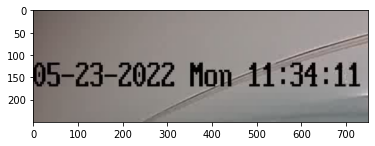

In [150]:
# Recognize DateTime stamp in image using pytesseract
cap = cv2.VideoCapture(TEST_VIDEO_PATH)
cap.set(cv2.CAP_PROP_POS_FRAMES, np.random.randint(0, cap.get(cv2.CAP_PROP_FRAME_COUNT)))
ret, img = cap.read()

# Resize image to 1920x1080
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

# Show image
plt.imshow(img)

# Crop the timestamp textbox
timestamp_textbox = img[TIMESTAMP_YMIN:TIMESTAMP_YMAX, TIMESTAMP_XMIN:TIMESTAMP_XMAX]

plt.imshow(timestamp_textbox)

timestamp_saved = timestamp_textbox

# Print dimensions of the image
print(img.shape)

OCR the timestamp from the image and convert it to datetime.

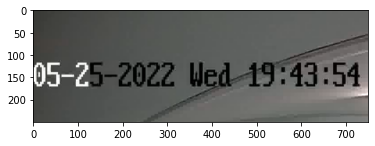

2022-05-25 19:43:54


In [543]:
def transform_timestamp(timestamp_textbox):
    """
    Transform timestamp textbox to grayscale and apply adaptive thresholding.
    """

    # Clean up timestamp textbox
    # Gray scale image
    timestamp_textbox = cv2.cvtColor(timestamp_textbox, cv2.COLOR_BGR2GRAY)
    timestamp_textbox = cv2.medianBlur(timestamp_textbox, 5)

    timestamp_textbox = cv2.threshold(timestamp_textbox, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Invert colors if black is dominant
    if np.mean(timestamp_textbox) < 30:
        timestamp_textbox = 255 - timestamp_textbox

    # Pad with white pixels
    timestamp_textbox = cv2.copyMakeBorder(timestamp_textbox, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=255)
    
    # Erosion
    kernel = np.ones((3, 3), np.uint8)
    timestamp_textbox = cv2.erode(timestamp_textbox, kernel, iterations=1)
    timestamp_textbox = cv2.dilate(timestamp_textbox, kernel, iterations=1)
    # Opening: erosion followed by dilation
    timestamp_textbox = cv2.morphologyEx(timestamp_textbox, cv2.MORPH_OPEN, kernel)

    # Sharpen image
    timestamp_textbox = cv2.filter2D(timestamp_textbox, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))

    return timestamp_textbox
    
def extract_timestamp(timestamp_textbox, optimize=False):
    """
    Extract timestamp from image.
    Params:
        timestamp_textbox (ndarray): image with timestamp textbox
        optimize (bool): don't perform some OCR quality increasing steps
    Returns:
        timestamp (str): timestamp in format 'YYYY-MM-DD HH:MM:SS', or None if no timestamp found
    """    
    DATE_START_X = 0
    DATE_END_X = 345
    TIME_START_X = 450
    TIME_END_X = 750

    DATE_TEXTBOX_SPLITS = [-1, 65, 125, 185, 250]
    for split in DATE_TEXTBOX_SPLITS:
        # Cut the textbox into two parts over X axis: date and time
        # It improves the accuracy of OCR
        date_textbox = timestamp_textbox[:, :DATE_END_X].copy()
        time_textbox = timestamp_textbox[:, TIME_START_X:TIME_END_X].copy()

        # The beam (an actual beam, the one used in construction) hinders OCR 
        # If the top left 50x50 pixels of the image aren't almost black,
        # convert almost pure white to pure black
        if np.all(timestamp_textbox[:50, :50] < 30):
            # Convert all not close to white pixels to black
            time_textbox[time_textbox < 200] = 0
        else:
            time_textbox[time_textbox > 220] = 0
            
        # Text in date textbox can sometimes be colored with black and white at the same time
        # If so, pytesseract will not recognize it
        # If failed to recognize, try to split date textbox into two parts and recognize separately
        if split == -1:
            date_textboxes = [date_textbox]
        else:
            date_textboxes = [date_textbox[:, :split], date_textbox[:, split:]]

        date_text = ''
        for date_textbox in date_textboxes:
            date_textbox = transform_timestamp(date_textbox)
            text = pytesseract.image_to_string(date_textbox, lang='eng', config='--psm 6')
            if split == DATE_TEXTBOX_SPLITS[2]:
                # Warning: Bad heuristics, replaces a totally valid day number "29" to "25"
                # But works for our case, for now we don't have "29" in dataset
                # It's an OCR error either way, let's skew to our favour
                text = re.sub(r'^9', '^5', text)
            date_text += text

        time_textbox = transform_timestamp(time_textbox)
        time_textbox = cv2.copyMakeBorder(time_textbox, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=255)

        # The beam staunchily refuses to be removed by any means
        # Hard code it if it's there: if there any black pixels in the top
        if time_textbox[:150, :].any():
            # Remove black from the top 150 pixels and the left 65 pixels
            time_textbox[:150, :] = 255
            time_textbox[:, :65] = 255
            time_textbox[150:160, 125:160] = 255

        time_text = pytesseract.image_to_string(time_textbox, config='--psm 7')
        time_text = re.sub(r'^6', '0', time_text)
        time_text = re.sub(r'^4', '1', time_text)

        date_text = re.sub(r'3022', '2022', date_text)
        date_text = re.sub(r'3202', '2022', date_text)

        img_text = date_text + ' ' + time_text
        img_text = re.sub(r'[?]', '7', img_text)
        # Forcing MM-DD-YYYY HH:MM:SS format: clean everything except digits
        img_text = re.sub(r'[^\d]', '', img_text)
        img_text = re.sub(r'(\d{2})(\d{2})(\d{4})(\d{2})(\d{2})(\d{2})', r'\1-\2-\3 \4:\5:\6', img_text)
        img_text = re.sub(r'^9', '0', img_text)

        # Convert timestamp to datetime object
        try:
            timestamp = datetime.datetime.strptime(img_text, '%m-%d-%Y %H:%M:%S')
            if timestamp.year != 2022:
                timestamp = None
            return timestamp
        except ValueError:
            if optimize:
                return None
    return None

plt.imshow(timestamp_saved)
plt.show()
print(extract_timestamp(timestamp_saved))

The dataset 'incorrect_ocr_timestamps.csv' contains the frames with OCR errors.

Correct OCR count: 11 - Incorrect OCR count: 0
2022-05-24 08:24:01


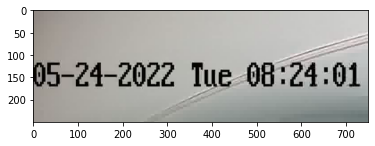

In [530]:
if ENABLE_DETAILED_TEST:
    # Load incorrect OCR timestamps from csv file
    incorrect_ocr_df = pd.read_csv('incorrect_ocr_timestamps.csv')

    # Rerun OCR on all incorrect timestamps
    # Collect statistics
    correct_ocr_count = 0
    incorrect_ocr_count = 0
    for idx, row in incorrect_ocr_df.iterrows():
        timestamp_textbox = cv2.imread(row['textbox_link'])
        timestamp_pred = extract_timestamp(timestamp_textbox)

        if str(timestamp_pred) == row['timestamp_textbox']:
            correct_ocr_count += 1
        else:
            incorrect_ocr_count += 1
            print(f"{row['textbox_link']} - {row['timestamp_textbox']} - {timestamp_pred}")

    print(f"Correct OCR count: {correct_ocr_count} - Incorrect OCR count: {incorrect_ocr_count}")

    # Load the first image from the incorrect_ocr_df dataset
    img = cv2.imread(incorrect_ocr_df.textbox_link.iloc[0])

    # Show the first image with the incorrect OCR timestamp
    plt.imshow(img)

    print(extract_timestamp(img))

# Preprocessing and cleaning the data

Train dataset contains the videos and the 'train.csv' file.

'Train.csv' file contains four columns: 'id', 'date' (timestamp), 'employee', 'action'

In [31]:
# Load the 'train.csv'
train_df = pd.read_csv('train.csv')


Clean up data, remove or modify data that makes no sense (like the action taking place in 2027).

In [32]:
train_df['date'] = train_df['date'].apply(lambda x: x.replace('2027', '2022'))

# Convert 'date' column to datetime format, accounting for the leap second
# Leap second is a one-second correction to the UTC time
# Data may contain entries like: '2019-01-01 00:00:60'
train_df['date'] = train_df['date'].apply(lambda x: datetime.datetime.strptime(':'.join(x.split(':')[:-1]), '%Y-%m-%d %H:%M')
                                          + datetime.timedelta(seconds=int(x.split(':')[-1])))
print(train_df.head())

     id                date  employee  action
0  1256 2022-05-24 08:08:36         2    15.0
1  1257 2022-05-24 08:08:37         2     4.0
2  1258 2022-05-24 08:12:13         3    15.0
3  1259 2022-05-24 08:12:25         3     2.0
4  1260 2022-05-24 08:12:42         3    12.0


Analyze the 'train.csv' file, count the number of action types and the number of employees.

Action types count in the dataset: 18
Employees in the dataset: 11


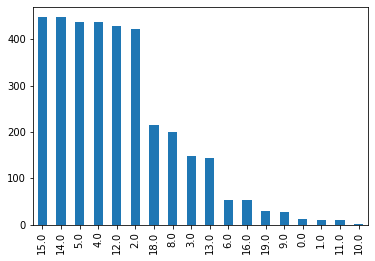

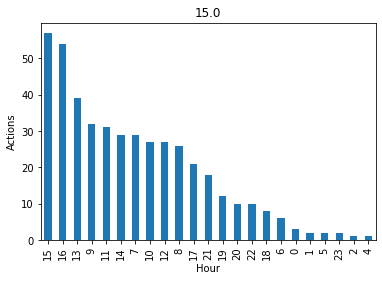

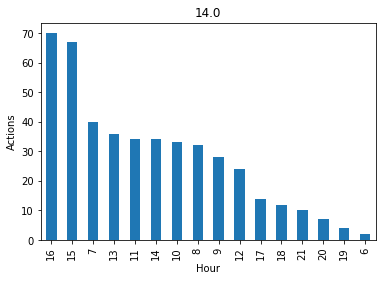

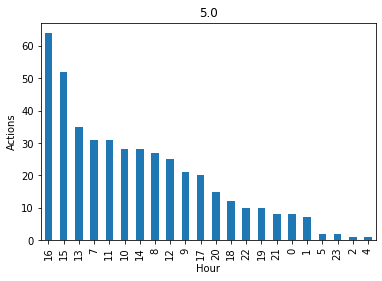

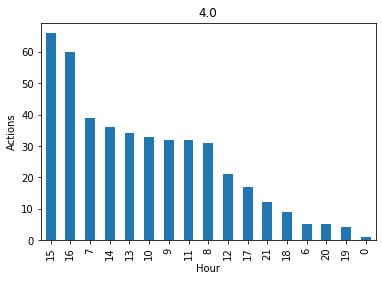

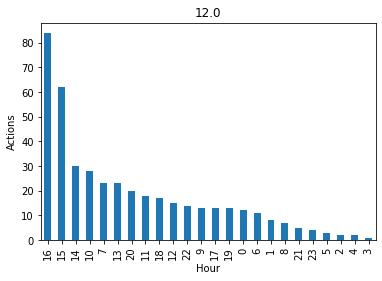

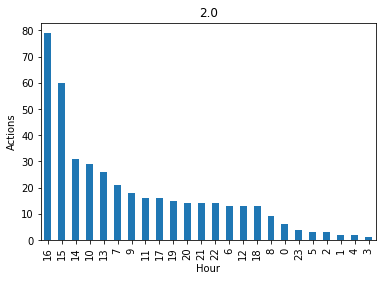

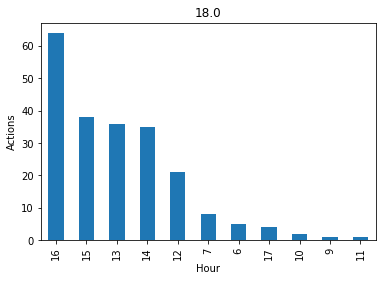

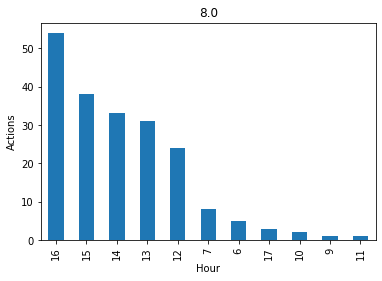

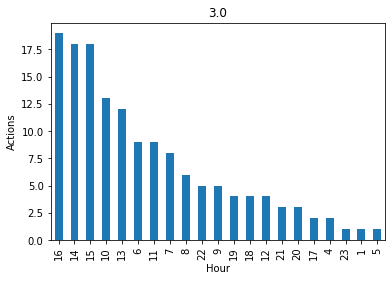

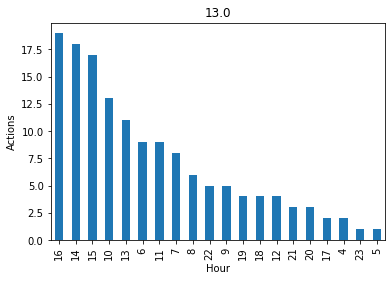

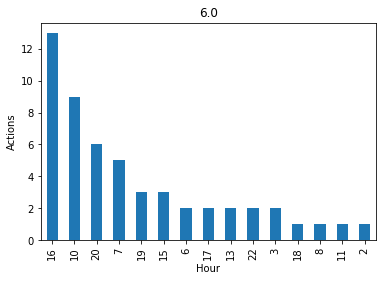

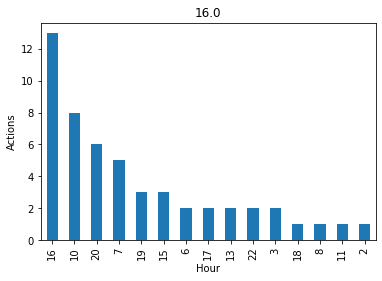

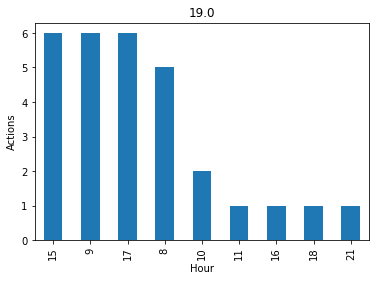

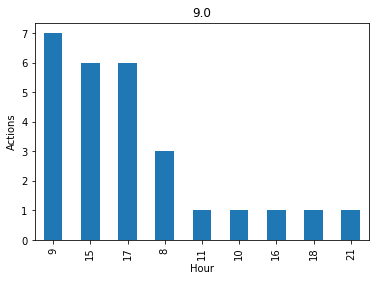

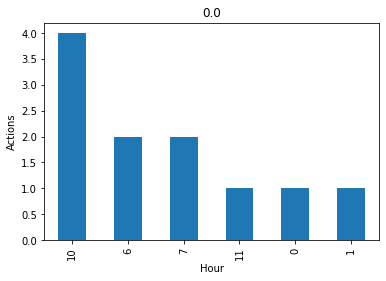

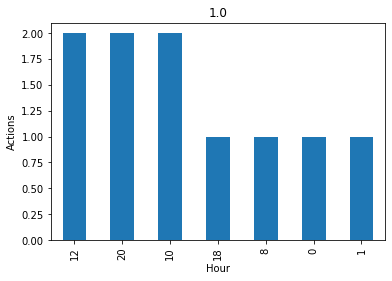

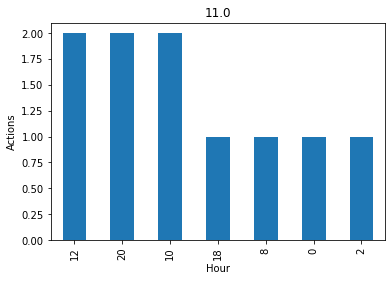

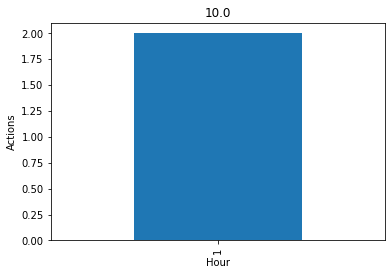

In [44]:
print(f"Action types count in the dataset: {len(train_df['action'].unique())}")
print(f"Employees in the dataset: {len(train_df['employee'].unique())}")

action_types_count = train_df['action'].value_counts()
action_types_count.plot(kind='bar')

for action_type in action_types_count.index:
    # Leave only action with the specified type
    action_df = train_df[train_df['action'] == action_type]

    # Bar plot actions per hour
    plt.figure()
    action_df['date'].dt.hour.value_counts().plot(kind='bar')
    plt.title(action_type)
    plt.xlabel('Hour')
    plt.ylabel('Actions')
    plt.show()
    break

In [519]:
def is_timestamp_in_action_timewindow(timestamp, action_idx, df = train_df, max_delta = datetime.timedelta(seconds=15)):
    """Check whether the timestamp is in the action timewindow.
    Args:
        timestamp (datetime.datetime): Timestamp to check
        action_idx (int): Index of the action in the dataframe
        df (pd.DataFrame): Dataframe with actions
    Returns:
        bool: True if the timestamp is in the action timewindow, False otherwise
    """
    if action_idx < 0 or action_idx >= len(df) or timestamp is None:
        return False
    # Is it within the time window of the action
    if df.iloc[action_idx]['date'] <= timestamp and timestamp - df.iloc[action_idx]['date'] <= max_delta:
        return True
    else:
        return False

def is_timestamp_before_action(timestamp, action_idx, df = train_df):
    """Check whether the timestamp is before the action.
    Args:
        timestamp (datetime.datetime): Timestamp to check
        action_idx (int): Index of the action in the dataframe
        df (pd.DataFrame): Dataframe with actions
    Returns:
        bool: True if the timestamp is before the action, False otherwise
    """
    if timestamp is None:
        return False
    if action_idx >= len(df):
        return True
    if action_idx < 0:
        return False
    return timestamp < df.iloc[action_idx]['date']

# Test searchsorted from Pandas
print(train_df.iloc[train_df.date.searchsorted(datetime.datetime(2022, 5, 25, 0, 0), side='left')])

id                         1807
date        2022-05-25 00:30:23
employee                     10
action                     12.0
Name: 551, dtype: object


In [ ]:
def search_frame_by_date(cap, date):
    """ Binary search for the frame that contains the given timestamp
    """
    l = 0
    r = cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1
    while l <= r:
        m = (l + r) // 2
        cap.set(cv2.CAP_PROP_POS_FRAMES, m)
        ret, img = cap.read()
        if not ret:
            break
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        save_img = img.copy()
        timestamp = extract_timestamp(img[TIMESTAMP_YMIN:TIMESTAMP_YMAX, TIMESTAMP_XMIN:TIMESTAMP_XMAX])
        # print(f"Frame {m}: {timestamp}")
        if timestamp is None:
            # Save to the ocr_error folder
            cv2.imwrite(f'ocr_error/test_timestamp_textbox_{m}.jpg', save_img[TIMESTAMP_YMIN:TIMESTAMP_YMAX, TIMESTAMP_XMIN:TIMESTAMP_XMAX])
            plt.imshow(save_img[TIMESTAMP_YMIN:TIMESTAMP_YMAX, TIMESTAMP_XMIN:TIMESTAMP_XMAX])
            plt.show()
            #return -1
            l += 3
            continue
        if timestamp < date:
            l = m + 1
        elif timestamp > date:
            r = m - 1
        else:
            return m
    # Approximate the frame
    return l

cap = cv2.VideoCapture('test.avi')
print(search_frame_by_date(cap, datetime.datetime.strptime('2022-05-23 21:47:06', '%Y-%m-%d %H:%M:%S')))
cap.release()

656068.0


Save action frames (0th, 50th, 150th, 250th) to the folder, to easily check the data.

In [537]:
def save_actions(df, video_path, save_dir="actions", from_action_id = 0):
    """Save the actions frames to a directory.
    Append the dataframe with the links to the saved frames.
    For now, save 4 action frames: 0, 50, 150, 250

    Df must have the following columns: "frame_0", "frame_50", "frame_150", "frame_250"
    """
    cap = cv2.VideoCapture(video_path)

    if from_action_id > 0:
        from_action_idx = df[df['id'] == from_action_id]
        if len(from_action_idx) > 0:
            cap.set(cv2.CAP_PROP_POS_FRAMES, search_frame_by_date(cap, df.iloc[from_action_idx.index[0]]['date']))
    action_start_frame = 0
    frame_idx = 0

    # Df indice of the current action (the last action that started before the current frame)
    action_idx = -1

    # The dict: action id -> number of processed frames
    current_actions = {}

    # For each action, find the corresponding frame in the video
    # Extract timestamp from the frame and compare it with the timestamp in the csv file
    while cap.isOpened() and action_idx < len(df):
        # Invariant: df.iloc[action_idx]['date'] <= timestamp < df.iloc[action_idx + 1]['date']
        # action_idx = -1 considered to be -inf, action_idx = len(df) considered to be +inf

        ret, img = cap.read()
        if not ret:
            break
        
        if frame_idx % cap.get(cv2.CAP_PROP_FPS) == 0:
        #if frame_idx % 50 == 0:
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            timestamp = extract_timestamp(img[TIMESTAMP_YMIN:TIMESTAMP_YMAX, TIMESTAMP_XMIN:TIMESTAMP_XMAX])
            # If the timestamp is not within the time window of the action, find the next action
            while (timestamp is not None) and not is_timestamp_before_action(timestamp, action_idx + 1, df):
                # The invariant must be maintained
                if (action_idx < len(df) and df.iloc[action_idx + 1].frame_0 is None and is_timestamp_in_action_timewindow(timestamp, action_idx + 1, df)
                    and df.iloc[action_idx + 1].id >= from_action_id):
                    current_actions[df.iloc[action_idx + 1].id] = 0
                action_idx += 1
            
            if is_timestamp_before_action(timestamp, action_idx, df) and timestamp is not None:
                # For some reason, the inv
                if action_idx >= 0:
                    print(f"Timestamp {timestamp} is before the action {action_idx}")
                    print(f"The action started at {df.iloc[action_idx].date}")
                # Something went wrong with the timestamps, clean the current actions
                current_actions = {}

                # Look for the action that the timestamp is within the time window of.
                # searchSorted returns the index of the first element that is greater than the timestamp
                # So, if it returns 0, the timestamp is before the first action, action_idx must be -1
                action_idx = df.date.searchsorted(timestamp) - 1
        
        for action_id, num_frames in current_actions.items():
            if num_frames == 0 or num_frames == 50 or num_frames == 150 or num_frames == 250:
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                # Just save the image
                img_name = f"action_{action_id}_{num_frames}.jpg"
                cv2.imwrite(os.path.join(save_dir, img_name), img)
                # Save the link to the image in the dataframe
                df.at[action_idx, f"frame_{num_frames}"] = img_name

            current_actions[action_id] += 1
        
        # Remove the actions that are finished (the last frame is 250)
        current_actions = {action_id: num_frames for action_id, num_frames in current_actions.items() if num_frames <= 250}

        frame_idx += 1


In [ ]:
if PREPARE_AUGMENTED_DATASET:
    saved_actions_df = train_df.copy()
    saved_actions_df['frame_0'] = None
    saved_actions_df['frame_50'] = None
    saved_actions_df['frame_150'] = None
    saved_actions_df['frame_250'] = None

It takes a long time to process the videos, avoid running it unless specifically preparing the dataset anew.

In [545]:
if PREPARE_AUGMENTED_DATASET:
    save_actions(saved_actions_df, TRAIN1_VIDEO_PATH)
    save_actions(saved_actions_df, TRAIN2_VIDEO_PATH)

    print(saved_actions_df.head())
    saved_actions_df.to_csv("train_with_links.csv", index=False)

Timestamp 2022-05-25 02:27:47 is before the action 630
The action started at 2022-05-25 07:27:15
Timestamp 2022-05-25 03:01:32 is before the action 694
The action started at 2022-05-25 09:01:25
Timestamp 2022-05-25 03:01:54 is before the action 696
The action started at 2022-05-25 09:01:48
Timestamp 2022-05-25 03:26:49 is before the action 700
The action started at 2022-05-25 09:11:39
Timestamp 2022-05-25 03:43:21 is before the action 708
The action started at 2022-05-25 09:43:08
Timestamp 2022-05-25 03:43:40 is before the action 709
The action started at 2022-05-25 09:43:29
Timestamp 2022-05-25 03:46:48 is before the action 713
The action started at 2022-05-25 09:46:32
Timestamp 2022-05-25 13:22:45 is before the action 966
The action started at 2022-05-25 15:22:38
Timestamp 2022-05-25 15:44:13 is before the action 1213
The action started at 2022-05-25 19:42:53
Timestamp 2022-05-25 15:51:17 is before the action 1214
The action started at 2022-05-25 19:44:12
Timestamp 2022-05-25 19:05:5

In [546]:
if PREPARE_AUGMENTED_DATASET:
    saved_actions_test_df = pd.read_csv("test.csv")
    saved_actions_test_df['frame_0'] = None
    saved_actions_test_df['frame_50'] = None
    saved_actions_test_df['frame_150'] = None
    saved_actions_test_df['frame_250'] = None
    save_actions(saved_actions_test_df, TEST_VIDEO_PATH, save_dir="actions_test")
    print(saved_actions_test_df.head())
    saved_actions_test_df.to_csv("test_with_links.csv", index=False)

Timestamp 2022-05-22 16:23:32 is before the action 204
The action started at 2022-05-22 17:37:13
Timestamp 2022-05-22 10:23:34 is before the action 162
The action started at 2022-05-22 16:21:28
Timestamp 2022-05-22 10:28:37 is before the action 168
The action started at 2022-05-22 16:27:48
Timestamp 2022-05-22 10:43:05 is before the action 168
The action started at 2022-05-22 16:27:48
Timestamp 2022-05-22 10:48:38 is before the action 168
The action started at 2022-05-22 16:27:48
Timestamp 2022-05-22 11:04:31 is before the action 168
The action started at 2022-05-22 16:27:48
Timestamp 2022-05-22 13:25:45 is before the action 107
The action started at 2022-05-22 14:49:50
Timestamp 2022-05-22 13:26:13 is before the action 110
The action started at 2022-05-22 15:25:45
Timestamp 2022-05-22 13:26:23 is before the action 111
The action started at 2022-05-22 15:26:12
Timestamp 2022-05-22 13:26:41 is before the action 112
The action started at 2022-05-22 15:26:34
Timestamp 2022-05-22 13:26:45 

Use YOLOv5 to detect the bounding boxes of the humans in the video frames.

In [574]:
def augment_dataset_from_images(df, save_path):
    """ Augment the dataset by extracting the bounding boxes of the employees from the images.

    Dataframe must have the following columns: "frame_0", "frame_50", "frame_150", "frame_250".
    They contain the links to the pre-saved frames.
    """
    for action_idx, row in df.iterrows():
        if action_idx % 100 == 0:
            print(f"Processing action {row.id}")
        
        average_persons_cnt = 0
        for bbox_id, frame_idx in enumerate([0, 50, 150, 250]):
            try:
                frame = cv2.imread(row[f"frame_{frame_idx}"])
            except FileNotFoundError:
                df.at[action_idx, f"bbox_{bbox_id}"] = [-1, -1, -1, -1]
                #print(f"File {row[f'frame_{frame_idx}']} not found")
                continue
            # Normalize the frame
            frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
            with torch.no_grad():
                results = yolo5(frame)
            results_df = results.pandas().xyxy[0]
            person_bboxes = results_df[results_df.name == 'person']
            if len(person_bboxes) == 0:
                df.at[action_idx, f"bbox_{bbox_id}"] = [-1, -1, -1, -1]
                continue
            else:
                person_bbox = person_bboxes.iloc[0]
                df.at[action_idx, f"bbox_{bbox_id}"] = [person_bbox.xmin, person_bbox.ymin, person_bbox.xmax, person_bbox.ymax]
                average_persons_cnt += len(person_bboxes)
                
        average_persons_cnt /= 4
        df.at[action_idx, "average_persons_cnt"] = average_persons_cnt
    df.to_csv(save_path, index=False)

In [575]:
if PREPARE_AUGMENTED_DATASET:
    train_with_links_df = pd.read_csv("train_with_links.csv")
    for frame_idx in [0, 50, 150, 250]:
        # To str
        train_with_links_df[f"frame_{frame_idx}"] = train_with_links_df[f"frame_{frame_idx}"].astype(str)
        train_with_links_df[f"frame_{frame_idx}"] = train_with_links_df[f"frame_{frame_idx}"].apply(lambda x: os.path.join("actions", x) if x != "nan" else x)
    print(train_with_links_df.head())

    augmented_train_with_links_df = train_with_links_df.copy()
    augmented_train_with_links_df['bbox_0'] = None
    augmented_train_with_links_df['bbox_1'] = None
    augmented_train_with_links_df['bbox_2'] = None
    augmented_train_with_links_df['bbox_3'] = None
    augmented_train_with_links_df['average_persons_cnt'] = None

    augment_dataset_from_images(augmented_train_with_links_df, "augmented_train_with_links.csv")
    print(augmented_train_with_links_df.head())


     id                 date  employee  action                    frame_0  \
0  1256  2022-05-24 08:08:36         2    15.0  actions\action_1256_0.jpg   
1  1257  2022-05-24 08:08:37         2     4.0  actions\action_1257_0.jpg   
2  1258  2022-05-24 08:12:13         3    15.0  actions\action_1258_0.jpg   
3  1259  2022-05-24 08:12:25         3     2.0  actions\action_1259_0.jpg   
4  1260  2022-05-24 08:12:42         3    12.0  actions\action_1260_0.jpg   

                     frame_50                    frame_150  \
0  actions\action_1256_50.jpg                          nan   
1  actions\action_1257_50.jpg  actions\action_1257_150.jpg   
2  actions\action_1258_50.jpg  actions\action_1258_150.jpg   
3  actions\action_1259_50.jpg  actions\action_1259_150.jpg   
4  actions\action_1260_50.jpg  actions\action_1260_150.jpg   

                     frame_250  
0                          nan  
1  actions\action_1256_250.jpg  
2  actions\action_1258_250.jpg  
3  actions\action_1259_250.jpg  

In [576]:
if PREPARE_AUGMENTED_DATASET:
    test_with_links_df = pd.read_csv("test_with_links.csv")
    for frame_idx in [0, 50, 150, 250]:
        # To str
        test_with_links_df[f"frame_{frame_idx}"] = test_with_links_df[f"frame_{frame_idx}"].astype(str)
        test_with_links_df[f"frame_{frame_idx}"] = test_with_links_df[f"frame_{frame_idx}"].apply(lambda x: os.path.join("actions_test", x) if x != "nan" else x)
    print(test_with_links_df.head())

    augmented_test_with_links_df = test_with_links_df.copy()
    augmented_test_with_links_df['bbox_0'] = None
    augmented_test_with_links_df['bbox_1'] = None
    augmented_test_with_links_df['bbox_2'] = None
    augmented_test_with_links_df['bbox_3'] = None
    augmented_test_with_links_df['average_persons_cnt'] = None

    augment_dataset_from_images(augmented_test_with_links_df, "augmented_test_with_links_df.csv")
    print(augmented_test_with_links_df.head())


    id                 date                        frame_0  \
0  135  2022-05-22 11:51:06  actions_test\action_135_0.jpg   
1  136  2022-05-22 11:51:25  actions_test\action_136_0.jpg   
2  137  2022-05-22 12:04:27  actions_test\action_137_0.jpg   
3  138  2022-05-22 12:07:56  actions_test\action_138_0.jpg   
4  139  2022-05-22 12:08:10  actions_test\action_139_0.jpg   

                         frame_50                        frame_150  \
0  actions_test\action_135_50.jpg  actions_test\action_135_150.jpg   
1  actions_test\action_136_50.jpg  actions_test\action_136_150.jpg   
2  actions_test\action_137_50.jpg  actions_test\action_137_150.jpg   
3  actions_test\action_138_50.jpg  actions_test\action_138_150.jpg   
4  actions_test\action_139_50.jpg                              nan   

                         frame_250  
0  actions_test\action_135_250.jpg  
1  actions_test\action_136_250.jpg  
2  actions_test\action_137_250.jpg  
3  actions_test\action_138_250.jpg  
4                    

In [801]:
def load_augmented_dataset(path):
    """ Load the augmented dataset and convert the bbox columns to lists of floats.
    Params:
        path: path to the csv file
    """
    df = pd.read_csv(path)
    for bbox_id in range(4):
        df[f"bbox_{bbox_id}"] = df[f"bbox_{bbox_id}"].apply(lambda x: list(map(float, x[1:-1].split(", "))))
    # Convert frame links to strings
    for frame_idx in [0, 50, 150, 250]:
        df[f"frame_{frame_idx}"] = df[f"frame_{frame_idx}"].apply(lambda x: str(x))
    return df

## Training auxiliary model
Here we train a primitive model to predict if the door is opened or closed, to enrich the dataset with the door state.

                         image  label  door_id
0    actions\action_1718_0.jpg      1        1
1  actions\action_4771_250.jpg      0        1
2  actions\action_4757_250.jpg      0        1
3  actions\action_4205_150.jpg      0        1
4  actions\action_1704_150.jpg      1        1


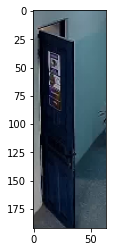

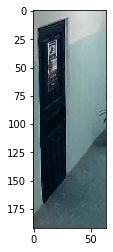

(96,)


In [693]:
# Read the information about doors from "door/doors.csv"
# It contains 3 columns: "image", "label" (open or closed), "door_id"
if PREPARE_AUGMENTED_DATASET:
    IMAGE_CROP_AREA = (1020, 510, 1300, 1350)
    DOOR_LABELS = ["open", "closed"]
    door_df = pd.read_csv(os.path.join("doors", "doors.csv"))
    door_df["image"] = door_df["image"].apply(lambda x: os.path.join("actions", x))
    door_df["label"] = door_df["label"].apply(lambda x: DOOR_LABELS.index(x))
    print(door_df.head())

    def load_door_image(img_path, convert_to_vector=True):
        """ Load the door image and crop it to the area of interest.
        """
        img = cv2.imread(img_path)
        cropped_img = img[IMAGE_CROP_AREA[1]:IMAGE_CROP_AREA[3], IMAGE_CROP_AREA[0]:IMAGE_CROP_AREA[2]]
        # Resize the image to 64 pixels width, keeping the aspect ratio
        height = int(cropped_img.shape[0] * 64 / cropped_img.shape[1])
        resized_img = cv2.resize(cropped_img, (64, height))
        if convert_to_vector:
            resized_img = np.array(resized_img).reshape(-1)
            # Convert the image to a vector
            return resized_img.reshape(-1)
        return resized_img

    # Split the data into train and validation
    # The train data must contain the same number of open and closed doors
    min_labels_cnt = min(door_df["label"].value_counts())
    door_train_df = door_df.groupby("label").apply(lambda x: x.sample(n=min_labels_cnt * 7 // 10,
                                                random_state=42))
    door_val_df = door_df[~door_df.index.isin(door_train_df.index)]

    # Show first opened and closed doors
    plt.imshow(load_door_image(door_df[door_df["label"] == 0]["image"].iloc[0], convert_to_vector=False))
    plt.show()
    plt.imshow(load_door_image(door_df[door_df["label"] == 1]["image"].iloc[0], convert_to_vector=False))
    plt.show()

    train_X, train_y = (door_train_df["image"].apply(load_door_image).values,
                        door_train_df["label"].values)

    print(train_X.shape)

In [1088]:
if PREPARE_AUGMENTED_DATASET:
    train_X = np.array([np.array(x) for x in train_X])
    # Use random forest to predict the door state
    door_clf = RandomForestClassifier(n_estimators=500, max_depth=50, random_state=42)
    door_clf.fit(train_X, train_y)

    val_X = np.array([np.array(load_door_image(x)) for x in door_val_df["image"].values])
    val_y = door_val_df["label"].values
    val_pred = door_clf.predict(val_X.reshape(val_X.shape[0], -1))
    print(f"Validation accuracy: {accuracy_score(val_y, val_pred)}")
    print(f"Validation F1 score: {f1_score(val_y, val_pred)}")

    # Save door classifier
    with open("door_classifier.pkl", "wb") as f:
        pickle.dump(door_clf, f)

Validation accuracy: 1.0
Validation F1 score: 1.0


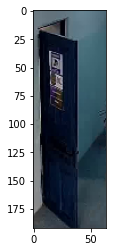

Predicted door state: open


In [709]:
if PREPARE_AUGMENTED_DATASET:
    # Predict on a random image from the "actions" folder
    random_img = random.choice(os.listdir("actions"))
    random_img_path = os.path.join("actions", random_img)
    random_img = load_door_image(random_img_path, convert_to_vector=False)
    plt.imshow(random_img)
    plt.show()

    prediction = door_clf.predict(load_door_image(random_img_path).reshape(1, -1))
    print(f"Predicted door state: {DOOR_LABELS[prediction[0]]}")

In [1089]:
def augment_dataset_with_door_state(df, clf, save_path):
    """ Add the door state to the dataset.
    """
    for i in [0, 50, 150, 250]:
        df[f"frame_{i}_door"] = -1
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Processed {idx} rows")
            df.to_csv(save_path, index=False)
        for frame_idx in [0, 50, 150, 250]:
            if os.path.exists(str(row[f"frame_{frame_idx}"])):
                door_state = clf.predict(load_door_image(row[f"frame_{frame_idx}"]).reshape(1, -1))[0]
                df.loc[idx, f"frame_{frame_idx}_door"] = door_state

if PREPARE_AUGMENTED_DATASET:
    # Load the door classifier
    with open("door_classifier.pkl", "rb") as f:
        door_clf = pickle.load(f)

    augmented_train_with_links_df = pd.read_csv("augmented_train_with_links.csv")
    for i in [0, 50, 150, 250]:
        augmented_train_with_links_df[f"frame_{frame_idx}"] = augmented_train_with_links_df[f"frame_{frame_idx}"].apply(lambda x: str(x))
    augment_dataset_with_door_state(augmented_train_with_links_df, door_clf, "augmented_train_with_links.csv")
    print(augmented_train_with_links_df["frame_0_door"].value_counts())

    augmented_train_with_links_df.to_csv("augmented_train_with_links.csv", index=False)

Processed 0 rows
Processed 100 rows
Processed 200 rows
Processed 300 rows
Processed 400 rows


KeyboardInterrupt: 

In [746]:
if PREPARE_AUGMENTED_DATASET:
    augmented_test_with_links_df = pd.read_csv("augmented_test_with_links.csv")
    for i in [0, 50, 150, 250]:
        augmented_test_with_links_df[f"frame_{frame_idx}"] = augmented_test_with_links_df[f"frame_{frame_idx}"].apply(lambda x: str(x))
    augment_dataset_with_door_state(augmented_test_with_links_df, door_clf, "augmented_test_with_links.csv")
    print(augmented_test_with_links_df["frame_0_door"].value_counts())

    augmented_test_with_links_df.to_csv("augmented_test_with_links.csv", index=False)

Processed 0 rows
Processed 100 rows
Processed 200 rows
Processed 300 rows
Processed 400 rows
Processed 500 rows
Processed 600 rows
Processed 700 rows
Processed 800 rows
Processed 900 rows
Processed 1000 rows
Processed 1100 rows
 1    524
 0    497
-1    100
Name: frame_0_door, dtype: int64


Train the model to recognize employees

In [1104]:
def exclude_unfit_actions(df):
    """ Exclude actions that are not suitable for training.
    """
    df = df[(~df['bbox_0'].isin([[-1, -1, -1, -1]])) |
            (~df['bbox_1'].isin([[-1, -1, -1, -1]])) |
            (~df['bbox_2'].isin([[-1, -1, -1, -1]])) |
            (~df['bbox_3'].isin([[-1, -1, -1, -1]]))]
    df = df[df["average_persons_cnt"] <= 1]
    return df

if PREPARE_AUGMENTED_DATASET:
    # Load the train dataset
    augmented_train_with_links_df = load_augmented_dataset("augmented_train_with_links.csv")

    print(len(augmented_train_with_links_df))
    # Filter out the actions without employees in any of the 4 frames (the ones where all bboxes are [-1, -1, -1, -1])
    augmented_train_with_links_df = exclude_unfit_actions(augmented_train_with_links_df)
    print(len(augmented_train_with_links_df))
    # Per each employee, select 5 samples from the dataset
    employee_imgs_df = augmented_train_with_links_df.groupby("employee").apply(lambda x: x.sample(n=10, random_state=42))
    employee_imgs_test_df = augmented_train_with_links_df[~augmented_train_with_links_df["id"].isin(employee_imgs_df["id"].unique())]
    employee_imgs_test_df = employee_imgs_test_df.groupby("employee").apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))
    print(employee_imgs_df.head())

3519
1385
                 id                 date  employee  action  \
employee                                                     
0        3482  4738  2022-05-28 07:32:21         0    13.0   
         2255  3511  2022-05-27 08:36:33         0    15.0   
         474   1730  2022-05-24 19:45:38         0    15.0   
         3286  4542  2022-05-27 16:45:04         0    13.0   
         1298  2554  2022-05-26 09:11:33         0    15.0   

                                 frame_0  ... door_state_after frame_0_door  \
employee                                  ...                                 
0        3482  actions\action_4738_0.jpg  ...                1           -1   
         2255  actions\action_3511_0.jpg  ...                1           -1   
         474   actions\action_1730_0.jpg  ...                1           -1   
         3286  actions\action_4542_0.jpg  ...                0           -1   
         1298  actions\action_2554_0.jpg  ...                0           -1   

 

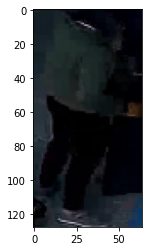

[ 26  36  44 ...  16  63 101]


In [924]:
def load_employee_image(img_path, bbox, convert_to_vector=True):
    """ Load the door image and crop it to the area of interest.
    """
    bbox = [int(x) for x in bbox]
    img = cv2.imread(img_path)
    img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    # Resize the image to 64 pixels width, keeping the aspect ratio
    #height = int(img.shape[0] * 64 / img.shape[1])
    resized_img = img
    resized_img = cv2.resize(img, (64, 128))
    #resized_img = cv2.resize(img, (64, height))
    if convert_to_vector:
        resized_img = np.array(resized_img).reshape(-1)
        # Convert the image to a vector
        return resized_img.reshape(-1)
    return resized_img

def get_employee_image_vector(row):
    """ Get the image vector for a given row.
    """
    for (frame_idx, bbox_idx) in [(0, 0), (50, 1), (150, 2), (250, 3)]:
        if row[f"bbox_{bbox_idx}"] != [-1, -1, -1, -1]:
            return load_employee_image(row[f"frame_{frame_idx}"], row[f"bbox_{bbox_idx}"])
    return None

if PREPARE_AUGMENTED_DATASET:
    # Test the load_employee_image function
    img = load_employee_image(employee_imgs_df["frame_50"].values[0], employee_imgs_df["bbox_1"].values[0], convert_to_vector=False)
    plt.imshow(img)
    plt.show()

    print(get_employee_image_vector(employee_imgs_df.iloc[0]))

In [1105]:
if PREPARE_AUGMENTED_DATASET:
    employee_img_clf = RandomForestClassifier(n_estimators=1000, max_depth=100, random_state=42)
    #balanced_employee_imgs_df = augmented_train_with_links_df.groupby("employee").apply(lambda x: x.sample(n=min(len(x), 15), random_state=42))
    #balanced_employee_imgs_test_df = augmented_train_with_links_df[~augmented_train_with_links_df["id"].isin(balanced_employee_imgs_df["id"].unique())].iloc[:300]
    employee_img_clf_train_df = augmented_train_with_links_df.iloc[:len(augmented_train_with_links_df) * 8 // 10]
    employee_img_clf_test_df = augmented_train_with_links_df.iloc[len(augmented_train_with_links_df) * 8 // 10:]

    
    employee_img_X = np.array([np.array(get_employee_image_vector(x)) for idx, x in employee_img_clf_train_df.iterrows()])
    employee_img_clf.fit(employee_img_X, employee_img_clf_train_df["employee"].values)
    employee_img_val_X = np.array([np.array(get_employee_image_vector(x)) for idx, x in employee_img_clf_test_df.iterrows()])
    employee_img_val_y = employee_img_clf_test_df["employee"].values
    # Test on the remaining samples
    print(f"F1 score: {f1_score(employee_img_val_y, employee_img_clf.predict(employee_img_val_X), average='weighted')}")
    print(f"Accuracy score: {accuracy_score(employee_img_val_y, employee_img_clf.predict(employee_img_val_X))}")

F1 score: 0.35338993136827074
Accuracy score: 0.3574007220216607


# Training employee classifier
Train the model to recognize the employees.

In [1035]:
# A Dataset class for for loading employee images, train and validation
class EmployeeImageDataset(Dataset):
    def __init__(self, df, transform=None, train=True):
        self.df = df
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = None
        for (frame_idx, bbox_idx) in [(0, 0), (50, 1), (150, 2), (250, 3)]:
            if row[f"bbox_{bbox_idx}"] != [-1, -1, -1, -1]:
                img = load_employee_image(row[f"frame_{frame_idx}"], row[f"bbox_{bbox_idx}"], convert_to_vector=False)
                break
        if img is None:
            raise ValueError("No image found for the given row")
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img, row["employee"]
        return img

if PREPARE_AUGMENTED_DATASET:
    balanced_employee_imgs_df = augmented_train_with_links_df.groupby("employee").apply(lambda x: x.sample(n=min(len(x), 15), random_state=42))
    balanced_employee_imgs_test_df = augmented_train_with_links_df[~augmented_train_with_links_df["id"].isin(balanced_employee_imgs_df["id"].unique())].iloc[:300]
    train_employee_img_loader = DataLoader(EmployeeImageDataset(balanced_employee_imgs_df, transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])), batch_size=8, shuffle=False)
    val_employee_img_loader = DataLoader(EmployeeImageDataset(balanced_employee_imgs_test_df, transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])), batch_size=8, shuffle=False)

    #employee_num = balanced_employee_imgs_df["employee"].max()
    employee_num = 11
    print(employee_num)

11


In [1030]:
# Lifted whole from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
import time
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_f1_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total_preds = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_preds.extend(preds.cpu().numpy())
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(dataloaders[phase].dataset.df["employee"].values, total_preds, average='weighted')
            
            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_f1_history.append(epoch_f1)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_f1_history


In [1103]:
def prepare_model_and_data(train_df, test_df, sample_mode = "frac"):
    """ Prepare the model and data for training """
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, 12)
    model.eval()
    model = model.to(device)

    train_employee_img_loader = DataLoader(EmployeeImageDataset(train_df, transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])), batch_size=8, shuffle=True)
    val_employee_img_loader = DataLoader(EmployeeImageDataset(test_df, transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])), batch_size=8, shuffle=False)

    # Observe that all parameters are being optimized
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    dataloaders_dict = {
        'train': train_employee_img_loader,
        'val': val_employee_img_loader
    }
    return model, criterion, optimizer, dataloaders_dict

if PREPARE_AUGMENTED_DATASET and not USE_PRETRAINED_MODEL:
    augmented_train_with_links_df = load_augmented_dataset("augmented_train_with_links.csv")
    augmented_train_with_links_df = exclude_unfit_actions(augmented_train_with_links_df)
    resnet_model, resnet_crit, resnet_opt, resnet_dataloaders = prepare_model_and_data(augmented_train_with_links_df.iloc[:len(augmented_train_with_links_df) * 8 // 10],
                                                                                    augmented_train_with_links_df.iloc[len(augmented_train_with_links_df) * 8 // 10:])
    resnet_model, resnet_f1_history = train_model(resnet_model, resnet_dataloaders, resnet_crit, resnet_opt, num_epochs=5)

Using cache found in C:\Users\USER/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/4
----------
train Loss: 2.1057 Acc: 0.2861 F1: 0.1619
val Loss: 4.0399 Acc: 0.2599 F1: 0.1337

Epoch 1/4
----------


KeyboardInterrupt: 

In [1090]:
# Save model to the disk
if not USE_PRETRAINED_MODEL:
    torch.save(resnet_model.state_dict(), "models/resnet_employee_classifier_5_epochs.pth")
    employee_img_clf_model = resnet_model

In [1094]:
employee_img_clf_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
employee_img_clf_model.fc = torch.nn.Linear(employee_img_clf_model.fc.in_features, 12)
employee_img_clf_model.load_state_dict(torch.load("models/resnet_employee_classifier_5_epochs.pth"))
employee_img_clf_model.eval()

Using cache found in C:\Users\USER/.cache\torch\hub\pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

3


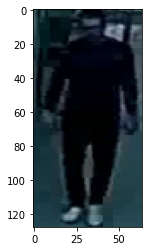

TypeError: pic should be Tensor or ndarray. Got <class 'list'>.

In [1108]:
if PREPARE_AUGMENTED_DATASET:
    # Predict on a random sample from the test set
    test_sample = balanced_employee_imgs_test_df[~balanced_employee_imgs_test_df['bbox_1'].isin([[-1, -1, -1, -1]])].sample(n=1)
    print(test_sample["employee"].values[0])
    test_sample_img = load_employee_image(test_sample["frame_50"].values[0], test_sample["bbox_1"].values[0], convert_to_vector=False)
    plt.imshow(test_sample_img)
    plt.show()
    print(torch.max(employee_img_clf_model(transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])([test_sample_img])), 1))

Assume an action take no less than 50 frames. It keeps the OCR overhead tolerable

Augment the dataset with the bounding boxes coords, without cropped images. 

# Training

Predict employees and actions
Train Random Forest classifier, Decision Tree classifier, Logistic Regression classifier.

In [603]:
def prepare_augmented_df(augmented_df):
    # Convert 'date' to datetime
    augmented_df.loc[:, 'date'] = pd.to_datetime(augmented_df['date'])
    
    # Fill missing values
    for i in range(1, 4):
        augmented_df[f'bbox_{i}'].fillna('[-1, -1, -1, -1]', inplace=True)
    # augmented_df['duration'].fillna(0, inplace=True)
    augmented_df['average_persons_cnt'].fillna(0, inplace=True)
    
    # Safe parse bboxes as lists
    for i in range(0, 4):
        bbox_name = 'bbox_{}'.format(i)
        augmented_df[bbox_name] = augmented_df[bbox_name].apply(lambda x: ast.literal_eval(x))
    
    # Split date into hour, minute, second
    augmented_df.loc[:, 'hour'] = augmented_df.date.dt.hour
    augmented_df.loc[:, 'minute'] = augmented_df.date.dt.minute
    augmented_df.loc[:, 'second'] = augmented_df.date.dt.second

    # Split bbox into xmin, ymin, xmax, ymax
    for i in range(0, 4):
        bbox_name = 'bbox_{}'.format(i)
        augmented_df.loc[:, bbox_name + '_xmin'] = augmented_df[bbox_name].apply(lambda x: x[0])
        augmented_df.loc[:, bbox_name + '_ymin'] = augmented_df[bbox_name].apply(lambda x: x[1])
        augmented_df.loc[:, bbox_name + '_xmax'] = augmented_df[bbox_name].apply(lambda x: x[2])
        augmented_df.loc[:, bbox_name + '_ymax'] = augmented_df[bbox_name].apply(lambda x: x[3])
    
    return augmented_df

In [771]:
# augmented_train_df = pd.read_csv('augmented_train2.csv')
augmented_train_df = pd.read_csv('augmented_train_with_links.csv')
augmented_train_df = prepare_augmented_df(augmented_train_df)
print(augmented_train_df.head())

     id                date  employee  action                    frame_0  ...  \
0  1256 2022-05-24 08:08:36         2    15.0  actions\action_1256_0.jpg  ...   
1  1257 2022-05-24 08:08:37         2     4.0  actions\action_1257_0.jpg  ...   
2  1258 2022-05-24 08:12:13         3    15.0  actions\action_1258_0.jpg  ...   
3  1259 2022-05-24 08:12:25         3     2.0  actions\action_1259_0.jpg  ...   
4  1260 2022-05-24 08:12:42         3    12.0  actions\action_1260_0.jpg  ...   

  bbox_2_ymax  bbox_3_xmin bbox_3_ymin  bbox_3_xmax  bbox_3_ymax  
0    -1.00000    -1.000000   -1.000000    -1.000000    -1.000000  
1    -1.00000    -1.000000   -1.000000    -1.000000    -1.000000  
2   745.06012  1429.568604  621.548279  1554.639648  1045.977539  
3    -1.00000    -1.000000   -1.000000    -1.000000    -1.000000  
4    -1.00000    -1.000000   -1.000000    -1.000000    -1.000000  

[5 rows x 38 columns]


In [776]:
# Print a number of entries for each employee
print(augmented_train_df.groupby('employee').count())

# Select first 80% of the data for training
employee_df = augmented_train_df.iloc[:int(len(augmented_train_df) * 0.8)]

# Select the entries for each employee
#employee_df = augmented_train_df.groupby('employee').apply(lambda x: x.sample(frac=0.8)).copy()
print(employee_df)

# Matrix of shape (n_samples, n_features), n_features = 4: hour, minute, second, action


# Exclude all ids that were used in the training set
employee_test_df = augmented_train_df[~augmented_train_df['id'].isin(employee_df['id'])].copy()
print(employee_test_df.groupby('employee').count())

           id  date  action  frame_0  frame_50  ...  bbox_2_ymax  bbox_3_xmin  \
employee                                        ...                             
0         611   611     611      508       507  ...          611          611   
1          62    62      62       53        53  ...           62           62   
2         266   266     266      242       242  ...          266          266   
3         610   610     610      541       541  ...          610          610   
4         106   106     106       98        98  ...          106          106   
5         478   478     478      419       419  ...          478          478   
6         322   322     322      275       274  ...          322          322   
7          33    33      33       33        33  ...           33           33   
8          41    41      41       33        33  ...           41           41   
10        410   410     410      334       334  ...          410          410   
11        580   580     580 

In [789]:
# Choose the best classifier
employee_clf_dict = {
    'RFC-500-50': "RandomForestClassifier(n_estimators=500, max_depth=50, random_state=0)",
    #'RFC-1000-100': "RandomForestClassifier(n_estimators=500, max_depth=100, random_state=0)",
    'KNN-3': "KNeighborsClassifier(n_neighbors=3)",
    'KNN-4': "KNeighborsClassifier(n_neighbors=4)",
    'KNN-5-2': "KNeighborsClassifier(n_neighbors=5, p=2)",
    #'RFC-100': RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
    #'DTC': DecisionTreeClassifier(max_depth=2)
}
used_columns_dict = {
    "Basic": ['hour', 'minute', 'action'],
    "BBoxes": ['hour', 'minute', 'action', 'bbox_1_xmin', 'bbox_1_ymin', 'bbox_1_xmax', 'bbox_1_ymax',
               'bbox_2_xmin', 'bbox_2_ymin', 'bbox_2_xmax', 'bbox_2_ymax',
                'bbox_3_xmin', 'bbox_3_ymin', 'bbox_3_xmax', 'bbox_3_ymax'],
    "BBoxesNoAction": ['hour', 'minute', 'bbox_1_xmin', 'bbox_1_ymin', 'bbox_1_xmax', 'bbox_1_ymax',
                       'bbox_2_xmin', 'bbox_2_ymin', 'bbox_2_xmax', 'bbox_2_ymax',
                       'bbox_3_xmin', 'bbox_3_ymin', 'bbox_3_xmax', 'bbox_3_ymax'],
}
# Add to the used columns all possible combinations of the bboxes
for i in range(4):
    for j in range(i+1, 4):
        used_columns_dict[f"BBoxes-{i}-{j}"] = ['hour', 'minute',
                                                f"bbox_{i}_xmin", f"bbox_{i}_ymin", f"bbox_{i}_xmax", f"bbox_{i}_ymax",
                                                f"bbox_{j}_xmin", f"bbox_{j}_ymin", f"bbox_{j}_xmax", f"bbox_{j}_ymax"]
        # used_columns_dict[f"BBoxes-{i}-{j}-action"] = ['hour', 'minute', 'action',
        #                                                f"bbox_{i}_xmin", f"bbox_{i}_ymin", f"bbox_{i}_xmax", f"bbox_{i}_ymax",
        #                                                f"bbox_{j}_xmin", f"bbox_{j}_ymin", f"bbox_{j}_xmax", f"bbox_{j}_ymax"]

for used_columns_type in list(used_columns_dict.keys()):
    used_columns_dict[f"{used_columns_type}-door"] = used_columns_dict[used_columns_type] + [f"frame_{i}_door" for i in [0]]

best_employee_clf = None
best_employee_preds = None
best_employee_used_columns = None
best_employee_clf_str = None
# Train a RandomForestClassifier on the data
# employee_clf = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
#clf = DecisionTreeClassifier(max_depth=2, random_state=0)
for clf_name, employee_clf_str in employee_clf_dict.items():
    for used_columns_type, used_columns in used_columns_dict.items():
        employee_clf = eval(employee_clf_str)
        X, y = employee_df[used_columns].values, employee_df['employee'].values
        employee_clf.fit(X, y)

        # Predict the employee for each entry not used in the training set
        employee_preds = employee_clf.predict(employee_test_df[used_columns].values)

        #print(employee_test_df.head())

        #print(classification_report(employee_test_df['employee'], employee_test_df['predicted_employee']))

        #print(f"Classifier {clf_name} Used columns: {used_columns_type} f1 {f1_score(employee_test_df['employee'], employee_preds, average='macro')}")
        # Choose the best classifier by F1 score
        if best_employee_clf is None or (f1_score(employee_test_df['employee'], employee_preds, average='macro') > 
                                        f1_score(employee_test_df['employee'], best_employee_preds, average='macro')):
            best_employee_clf = employee_clf
            best_employee_clf_str = employee_clf_str
            best_employee_preds = employee_preds
            best_employee_used_columns = used_columns
            print(f"Classifier {clf_name} Used columns: {used_columns_type} f1 {f1_score(employee_test_df['employee'], employee_preds, average='macro')}")
            #print(f"Best classifier: {clf_name}")

#employee_clf = best_employee_clf
employee_clf = eval(best_employee_clf_str)
employee_used_columns = best_employee_used_columns

print(classification_report(employee_test_df['employee'], best_employee_preds))

employee_clf.fit(augmented_train_df[employee_used_columns].values, augmented_train_df['employee'].values)

Classifier RFC-500-50 Used columns: Basic f1 0.0773384135583103
Classifier RFC-500-50 Used columns: BBoxes f1 0.0988429944255686
Classifier KNN-3 Used columns: BBoxes f1 0.09939265557557085
Classifier KNN-3 Used columns: BBoxes-door f1 0.10410591545774323
              precision    recall  f1-score   support

           0       0.48      0.21      0.29       266
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.13      0.39      0.19        57
           4       0.00      0.00      0.00         0
           5       0.27      0.09      0.13       147
           6       0.06      0.09      0.07        22
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.56      0.39      0.46       212

    accuracy                           0.25       704
   macro avg       0.14      0.11      0

c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier(n_neighbors=3)

In [779]:
# Choose the best models based on mean f1-scores

# Split onto train and test, minding the balance of action classes
# action_train_df = augmented_train_df.groupby('action').apply(lambda x: x.sample(frac=0.8)).copy()
# action_train_df = augmented_train_df.groupby('action').apply(lambda x: x.sample(n=min(33, len(x) // 10 * 9))).copy()

# Get first 80% of the data
# action_train_df = augmented_train_df.groupby('action').apply(lambda x: x.iloc[:int(len(x) * 0.8)]).copy()
action_train_df = augmented_train_df.iloc[:int(len(augmented_train_df) * 0.8)].copy()

action_test_df = augmented_train_df[~augmented_train_df['id'].isin(action_train_df['id'])].copy()

In [796]:
# Choose the best models based on mean f
action_clf_dict = {
    "RFC-1000": "RandomForestClassifier(n_estimators=1000, max_depth=50, random_state=0)",
    "KNN-3": "KNeighborsClassifier(n_neighbors=3)",
    "KNN-4": "KNeighborsClassifier(n_neighbors=4)",
    "PER": "Perceptron(tol=1e-3, random_state=0)",
    #"knn": "KNeighborsClassifier(n_neighbors=3)",
    #"GNB": "GaussianNB()",
    #"RFC-100": "RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)",
    #"DTC": "DecisionTreeClassifier(max_depth=50, random_state=0)",
}

def engineer_features_for_action(used_columns_dict={}, include_bboxes=True, combine_bboxes=False,
                                 include_door=False, combine_door=False, use_minute=False,
                                 use_average_persons_cnt=False):
    """ Engineer features for action classification
    Returns:
        used_columns_dict: dict of used columns (features) for each action
    """
    date_time_features = ['hour'] + (['minute'] if use_minute else [])
    used_columns_dict["Basic"] = date_time_features
    bbox_features = []
    if include_bboxes:
        for i in range(0, 4):
            bbox_features += [f"bbox_{i}_xmin", f"bbox_{i}_ymin", f"bbox_{i}_xmax", f"bbox_{i}_ymax"]
        used_columns_dict["BBox-all"] = date_time_features + bbox_features
        # Shows good results
        used_columns_dict["BBox-0-1"] = date_time_features + bbox_features[:8]
        if combine_bboxes:
            # Possible combinations for 4 bboxes
            for i in range(0, 4):
                for j in range(i + 1, 4):
                    used_columns_dict[f"Bbox-{i}-{j}"] = date_time_features + [f"bbox_{i}_xmin", f"bbox_{i}_ymin", f"bbox_{i}_xmax", f"bbox_{i}_ymax",
                                                                               f"bbox_{j}_xmin", f"bbox_{j}_ymin", f"bbox_{j}_xmax", f"bbox_{j}_ymax"]
    if include_door:
        door_features = [f"frame_{i}_door" for i in [0, 50]]
        # Combine with previous features
        for used_columns_type in list(used_columns_dict.keys()):
            used_columns_dict[f"{used_columns_type}-door"] = used_columns_dict[used_columns_type] + door_features

    if use_average_persons_cnt:
        # Append average persons count for all
        used_columns_dict = {f"{used_columns_type}": used_columns_dict[used_columns_type] + ["average_persons_cnt"] for used_columns_type in used_columns_dict}

    return used_columns_dict

used_columns_dict = engineer_features_for_action(use_average_persons_cnt=True, include_door=True)

best_action_clf = None
best_action_preds = None
best_action_used_columns = None
best_action_clf_str = None
for clf_name, action_clf_str in action_clf_dict.items():
    for used_columns_type, used_columns in used_columns_dict.items():
        action_clf = eval(action_clf_str)
        X, y = action_train_df[used_columns].values, action_train_df['action'].values
        action_clf.fit(X, y)

        # Predict the action for each entry not used in the training set
        action_preds = action_clf.predict(action_test_df[used_columns].values)
        
        if best_action_clf is None or (f1_score(action_test_df['action'], action_preds, average='macro')
                                       > f1_score(action_test_df['action'], best_action_preds, average='macro')):
            best_action_clf = action_clf
            best_action_preds = action_preds
            best_action_used_columns = used_columns
            best_action_clf_str = action_clf_str
        
            print(f"{clf_name} Used columns: {used_columns_type} F1: {f1_score(action_test_df['action'], action_preds, average='macro')}")

print(classification_report(action_test_df['action'], best_action_preds))
action_test_df['predicted_action'] = best_action_preds

print(action_test_df.head())

#action_clf = best_action_clf
action_clf = eval(best_action_clf_str)
action_used_columns = best_action_used_columns

print(action_used_columns)
# action_clf = RandomForestClassifier(n_estimators=300, max_depth=2, random_state=0)
action_clf.fit(action_train_df[action_used_columns].values, action_train_df['action'].values)

RFC-1000 Used columns: Basic F1: 0.0783578663664365
RFC-1000 Used columns: BBox-all F1: 0.1786091243359385
RFC-1000 Used columns: BBox-0-1 F1: 0.18734216642628304


c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Anaconda3\envs\Kaggle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\USER\Anaconda3\envs\K

              precision    recall  f1-score   support

         2.0       0.26      0.16      0.20       102
         3.0       0.00      0.00      0.00        27
         4.0       0.13      0.64      0.22        59
         5.0       0.16      0.06      0.08        53
         6.0       0.00      0.00      0.00         9
         8.0       0.33      0.06      0.11        94
        11.0       0.00      0.00      0.00         0
        12.0       0.39      0.35      0.37       115
        13.0       0.27      0.27      0.27        26
        14.0       0.31      0.39      0.34        62
        15.0       0.40      0.40      0.40        45
        16.0       0.67      0.22      0.33         9
        18.0       0.55      0.21      0.31       103
        19.0       0.00      0.00      0.00         0

    accuracy                           0.25       704
   macro avg       0.25      0.20      0.19       704
weighted avg       0.32      0.25      0.24       704

        id               

RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=0)

Train on the entire dataset

In [652]:
action_clf.fit(action_train_df[action_used_columns].values, action_train_df['action'].values)

RandomForestClassifier(max_depth=50, n_estimators=500, random_state=0)

# Prediction

In [1109]:
prepared_augmented_test_df = pd.read_csv('augmented_test_with_links.csv')

prepared_augmented_test_df = prepare_augmented_df(prepared_augmented_test_df)

# Predict the action for each entry in the test set
prepared_augmented_test_df['action'] = action_clf.predict(prepared_augmented_test_df[action_used_columns].values)

In [1110]:
prepared_augmented_test_df['employee'] = employee_clf.predict(prepared_augmented_test_df[employee_used_columns].values)
print(prepared_augmented_test_df.groupby('employee').count())
#print(prepared_augmented_test_df.groupby('action').count())

           id  date  frame_0  frame_50  frame_150  ...  bbox_3_xmin  \
employee                                           ...                
0         276   276      243       243        187  ...          276   
1          54    54       42        42         31  ...           54   
2         205   205      194       194        150  ...          205   
3         257   257      242       242        193  ...          257   
4          33    33       27        27         19  ...           33   
5         113   113      103       103         71  ...          113   
6          92    92       84        84         66  ...           92   
7           2     2        2         2          2  ...            2   
8           6     6        6         6          5  ...            6   
10         57    57       54        54         34  ...           57   
11         26    26       24        24         13  ...           26   

          bbox_3_ymin  bbox_3_xmax  bbox_3_ymax  action  
employee          

In [1080]:
# Prepare the dataloader for the test set
model_augmented_test_df = prepared_augmented_test_df.copy()
model_augmented_test_df = model_augmented_test_df[model_augmented_test_df['average_persons_cnt'] <= 1]
# Remove frames without persons
model_augmented_test_df = model_augmented_test_df[(~model_augmented_test_df['bbox_0'].isin([[-1, -1, -1, -1]])) |
                                                  (~model_augmented_test_df['bbox_1'].isin([[-1, -1, -1, -1]])) |
                                                  (~model_augmented_test_df['bbox_2'].isin([[-1, -1, -1, -1]])) |
                                                  (~model_augmented_test_df['bbox_3'].isin([[-1, -1, -1, -1]]))]

test_employee_img_loader = DataLoader(EmployeeImageDataset(model_augmented_test_df, transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]), train=False), batch_size=8, shuffle=False)

employee_img_clf_model = resnet_model
employee_img_clf_model.eval()

# Predict using the employee_img_clf_model and save to the dataframe
batch_idx = 0
for input in test_employee_img_loader:
    input = input.to(device)
    output = employee_img_clf_model(input)
    _, preds = torch.max(output, 1)
    for i in range(len(preds)):
        model_augmented_test_df.iloc[batch_idx * 8 + i, model_augmented_test_df.columns.get_loc('employee')] = preds[i].item()
    batch_idx += 1

In [1081]:
# Update the prepared_augmented_test_df with the predictions from the model
# for the ids appearing in model_augmented_test_df
prepared_augmented_test_df.loc[prepared_augmented_test_df['id'].isin(model_augmented_test_df['id']), 'employee'] = model_augmented_test_df['employee']

print(prepared_augmented_test_df.groupby('employee').count())

           id  date  frame_0  frame_50  frame_150  ...  bbox_3_xmin  \
employee                                           ...                
0         201   201      168       168        131  ...          201   
1          44    44       32        32         28  ...           44   
2         165   165      154       154        110  ...          165   
3         155   155      140       140        118  ...          155   
4          79    79       73        73         50  ...           79   
5         177   177      167       167        111  ...          177   
6         170   170      161       161        123  ...          170   
8           5     5        5         5          4  ...            5   
10         33    33       31        31         28  ...           33   
11         92    92       90        90         68  ...           92   

          bbox_3_ymin  bbox_3_xmax  bbox_3_ymax  action  
employee                                                 
0                 201          

In [1111]:
for idx, row in prepared_augmented_test_df.iterrows():
   # Use employee_img_clf if there is a frame with a person
   img_vec = get_employee_image_vector(row)
   if img_vec is not None and row["average_persons_cnt"] <= 1:
      prepared_augmented_test_df.at[idx, 'employee'] = employee_img_clf.predict(img_vec.reshape(1, -1))[0]



In [1112]:
# Prepare the submission file, save 'id', 'date', 
test_df = pd.read_csv('test.csv')
submission_df = test_df[['id']].copy()
submission_df['employee'] = prepared_augmented_test_df['employee']
submission_df['action'] = prepared_augmented_test_df['action']

# Save the submission file
submission_df.to_csv(f"submission_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv", index=False)